## <center> École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8460 – Traitement automatique de la langue naturelle <br> </center>
## <center> TP4 - Les LLMs et la génération augmentée de récupération (RAG) pour les questions-réponses<br> Automne 2024 </center>


## Identification de l'équipe:

### Groupe de laboratoire: G01_B1

### Equipe numéro: Eq01

### Membres:

- Zoé Paradis 2008732 (33% de contribution. nature de la contribution : Elle a réalisé tous les exercices de les section 1,2,3 de manière individuelle comme chaque coéquipier. Puis les codes réalisés ont été comparé avec les autres membres pour valider les réponses obtenues. Pour la section 4, chaque coéquipière ont implémenté et testé plusieurs idées différentes inspiré de l’état de l’art pour finalement combiner les meilleures méthodes.)
- Mahacine Ettahri 2312965 (33% de contribution. nature de la contribution : Elle a réalisé tous les exercices de les section 1,2,3 de manière individuelle comme chaque coéquipier. Puis les codes réalisés ont été comparé avec les autres membres pour valider les réponses obtenues. Pour la section 4, chaque coéquipière ont implémenté et testé plusieurs idées différentes inspiré de l’état de l’art pour finalement combiner les meilleures méthodes.)
- Xuewei Li 1879356 (33% de contribution, nature de la contribution : Elle a réalisé tous les exercices de les section 1,2,3 de manière individuelle comme chaque coéquipier. Puis les codes réalisés ont été comparé avec les autres membres pour valider les réponses obtenues. Pour la section 4, chaque coéquipière ont implémenté et testé plusieurs idées différentes inspiré de l’état de l’art pour finalement combiner les meilleures méthodes.)

## 1. Introduction

### 1.1. Description du TP4

Dans ce TP, vous allez travailler sur un système de **génération augmentée de récupération**, ou **RAG** (pour Retrieval Augmented Generation en anglais) qui combine des modèles de langue génératifs et de recherche d'information.

Étant donnée une question, il faudra retrouver les passages les plus pertinents  avec un modèle de recherche. Ensuite, il faudra générer une réponse à la question en utilisant ces passages de texte. Vous aurez finalement à trouver des manières d'améliorer les performances de votre modèle RAG.

L'ensemble est noté sur 100 points.

### Description des données

Les passages donnés sont des textes en anglais de quelques phrases sur divers sujets. Par exemple, les mathématiques, la physique, la chimie, la biologie l'informatique, la musique et la psychologie. En général, les textes abordent des sujets très spécifiques reliés à un domaine. Par exemple, il pourrait y avoir 1000 textes parlant d'informatique et 100 qui abordent, à leur manière, la notion de mémoire. Parmi ces 100 passages, 5 pourraient aborder la mémoire dans un processeur spécifique.

En ce qui concerne les questions, elles sont basées sur les sujets de certains textes précis et on peut y répondre à l'aide d'au moins un des textes. Dans certains cas, plusieurs textes sont nécessaires pour répondre à la question. Par exemple, plusieurs textes pourraient aborder le processeur Intel i7-13700k, mais la question pourrait nécessiter l'information de tous ces textes pour trouver la réponse.
Les questions ont été créées pour faire en sorte que les réponses soient assez courtes. Il peut s'agir d'un simple nombre ou de quelques mots (< 30 mots).


Vous trouverez ~ 13 000 passages dans le corpus pour ~ 1 700 paires de questions / réponses dans le jeu d'entraînement et ~ 500 dans le jeu de validation. Vous devez prédire 500 réponses aux questions du jeu de test.

### Exemple

Par exemple, pour la question

> What type of bonds are used to form branches in glycogen?

Avec l'approche RAG, plutôt que de générer la réponse directement, on va d'abord chercher dans un corpus de passages. Dans cet exemple, un des passages pertinents est :

> **Glycogen Structure and Function** : Glycogen is a molecular polymer of glucose used for energy storage. It is composed of linear chains of glucose molecules linked by α-1,4-glycosidic bonds, with branches formed off the chain via α-1,6-glycosidic bonds. The branches provide additional ""free ends"" for linear chains, allowing for faster glucose release.

Puis on génère une réponse conditionnée par les passages pertinents :

> α-1,6-glycosidic bonds

### Motivation

Le RAG est une approche très populaire en ce moment. Elle permet notamment d'avoir des sources qui supportent les réponses générées, ce qui peut être utile pour la vérification de faits ou pour contrôler les hallucinations. De plus, elle permet d'intégrer des connaissances externes et récentes dans les modèles de génération sans avoir à les ré-entraîner.

### Objectif du TP

Dans ce TP, vous implémenterez plusieurs systèmes de question-réponse. D'abord, vous testerez une approche de prompting qui n'utilise aucun passage pour aider le modèle de génération. Puis vous implémenterez un système figé qui utilise un modèle de plongements figé pour retrouver les $k$ passages les plus pertinents. Ces passages seront ensuite donnés à un modèle de génération figé aussi.

Enfin, vous implémenterez votre propre méthode dans l'objectif d'atteindre les meilleures performances dans la compétition Kaggle.

### Jeux de données

Vous avez 4 fichiers à votre disposition :
- 'rag_texts.csv' : le corpus de passages extraits de Wikipédia.
  - **id** : l'identifiant unique du passage.
  - **text** : le texte du passage.
- 'rag_questions_train.csv', 'rag_questions_val.csv' et 'rag_questions_test.csv' : les questions d'entraînement, de validation et de test.
  - **id** : l'identifiant unique de la question.
  - **question** : La question.
  - **text_id** (sauf pour le fichier de test) : la liste des identifiants des passages pertinents du corpus 'rag_texts.csv' pour la question.
  - **answer** (sauf pour le fichier de test) : la réponse à la question.

### Contraintes

- **Modèle génératif** : pour des raisons d'équité, le seul modèle de génération que vous pouvez utiliser est [microsoft/Phi-3-mini-128k-instruct](https://huggingface.co/microsoft/Phi-3-mini-128k-instruct), disponible sur Hugging Face. Cette contrainte permet de mieux comparer les différentes approches et d'éviter que la performance soit uniquement due à un modèle de génération plus performant.
- Données externes : vous ne pouvez pas utiliser de données externes pour entraîner vos modèles, seulement les données fournies.
- Modèles de plongements à utiliser: [BAAI/bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5)

### 1.2. Librairies permises

Vous pouvez utiliser les librairies suivantes
- Numpy
- Pandas
- HuggingFace
- nltk
- SpaCy
- PyTorch
- faiss
- Langchain
- re


- Pour toute autre librairie, demandez à votre chargé de laboratoire

### 1.3. Infrastructure

- Vous avez accès aux GPU du local L-4818. Dans ce cas, vous devez utiliser le dossier temp (voir le tutoriel VirtualEnv.pdf)
- Vous pouvez aussi utiliser l’environnement Google Colab :  https://colab.research.google.com/

### 1.4. Remise

### Échéance

Fin de la session. La date précise sera indiquée dans les boites de remise sur Moodle.


### Livrables

Vous devez remettre votre notebook sur Moodle et Gradescope en ipynb et pdf. Pour Gradescope vous devez associer les numéros de questions avec vos réponses dans le pdf grâce à l'outil que fournit Gradescope.


### Critères
1. Implantation correcte et efficace
2. Richesse de la solution proposée
3. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
4. Commentaires clairs et informatifs
5. Aspect novateur
6. État de l'art synthétisé
7. Performance attendue des modèles
8. Réponses correctes/sensées aux questions de réflexion ou d'analyse

### CODE D’HONNEUR
- __Règle 1__:  Le plagiat de code est bien évidemment interdit. Toute utilisation de code doit être référencée adéquatement. L’utilisation de code ne peut concerner que les architectures de base (par exemple le Transformer). Vous __ne pouvez pas__ soumettre un code écrit par quelqu’un d’autre.
- __Règle 2__: Vous êtes libres de discuter des idées et des détails de mise en œuvre avec d'autres équipes. Cependant, vous ne pouvez en aucun cas consulter le code d'une autre équipe INF8460, ou incorporer leur code dans votre TP.
- __Règle 3__:  Vous ne pouvez pas partager votre code publiquement (par exemple, dans un dépôt GitHub public) tant que le cours n'est pas fini.


### 1.5. Kaggle

La compétion Kaggle sera accessible ici: https://www.kaggle.com/t/c970abbf273b4e13a642fce3bfe219be.

Vous devez recréer des équipes de 3 personnes sur Kaggle avec le même nom d'équipe que sur Moodle ainsi que les mêmes membres.

Le TP4 se fera sous forme d’une compétition Kaggle.  Vous devrez utiliser l’environnement Kaggle pour la soumission et l’évaluation de vos meilleurs modèles.  
Pour tester votre modèle au fur et à mesure, vous aurez le droit à 4 soumissions par jour sur Kaggle. Il y aura deux types de résultats : votre « private leaderboard » et votre « public leaderboard » :
- Le « public leaderboard » est calculé sur approximativement 30% des données de test, choisies aléatoirement par Kaggle. Ce score est public et est calculé sur la même tranche de données pour tous les participants.
- Le « private leaderboard » est calculé sur approximativement 70% des données de test et n’est visible qu’à la fin de la compétition. Le résultat final sera basé sur ce leaderboard. Si aucune soumission n’est choisie, la soumission avec le meilleur score sur le « public leaderboard » sera utilisée pour calculer le score sur le « private leaderboard ».

Pour l’évaluation, vous devrez soumettre un fichier de données _tp4_submission.csv_ du même format que le fichier _sample_submission.csv_ (disponible sur le site de la compétition et Moodle).


### 1.6. Description des données et métriques d’évaluation

Dans votre fichier de soumission, il doit y avoir une colonne _id_ et une colonne _answer_. La colonne _id_ doit correspondre à l'identifiant unique de la question et la colonne _answer_ doit correspondre à la réponse générée par votre modèle.

Nous utiliserons la métrique **BLEU**, vue en cours, pour évaluer les réponses générées par rapport au jeu de référence (gold standard).

In [1]:
pip install -U trl rank_bm25 faiss-cpu datasets accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.9/310.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 

In [2]:
# Import des librairies
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, DataCollatorWithPadding, BitsAndBytesConfig, TrainingArguments,Trainer, set_seed
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from peft import LoraConfig, prepare_model_for_kbit_training, TaskType, PeftModel

from datasets import load_dataset, Dataset
from nltk.translate.bleu_score import sentence_bleu
import nltk
import faiss
import re
import random
import math
from rank_bm25 import BM25Okapi
from trl import SFTTrainer

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
# Si vous stockez vos données sur Google Drive
from google.colab import drive
drive.mount('/content/drive')
# root_path = '/content/drive/MyDrive/'
# data_path = root_path + 'data/'

Mounted at /content/drive


In [4]:
root_path = './'
data_path = root_path + 'data/'

## 2. Analyse exploratoire et modèle de génération simple (15 points)

Pour commencer ce TP, et pour fixer des modèles de base (baselines), vous allez utiliser un modèle de génération simple pour répondre aux questions. Vous utiliserez le modèle de génération **'microsoft/Phi-3-mini-128k-instruct'** disponible sur Hugging Face. Dans cette partie, vous devez simplement générer des réponses aux questions de l'ensemble de validation (_questions_val.csv_) sans utiliser de passages pour aider le modèle.

### 2.1. Chargement des données (5 points)

#### 2.1.1 Taille des données (1 point)

Affichez la taille de tous les jeux de données et quelques questions de l'ensemble d'entraînement

In [5]:
# TODO
texts_dataset = pd.read_csv(data_path + 'texts.csv')
train_dataset = pd.read_csv(data_path + 'questions_train.csv')
val_dataset = pd.read_csv(data_path + 'questions_val.csv')
test_dataset = pd.read_csv(data_path + 'questions_test.csv')

print("Taille du corpus de passages : ", len(texts_dataset))
print("Taille des questions d'entraînement : ", len(train_dataset))
print("Taille des questions de validation : ", len(val_dataset))
print("Taille des questions de test : ", len(test_dataset))
# END TODO

Taille du corpus de passages :  13314
Taille des questions d'entraînement :  1747
Taille des questions de validation :  500
Taille des questions de test :  500


#### 2.1.2 Analyse exploratoire (4 points)

a) Sur l'ensemble d'entraînement, affichez :
- Le nombre moyen de mots dans une question
- Le nombre moyen de mots dans une réponse
- Le nombre moyen de passages nécessaires pour répondre à une question
- Le nombre minimal de passages nécessaires pour répondre à une question
- Le nombre maximal de passages nécessaires pour répondre à une question


In [ ]:
# TODO
nbr_words_question = train_dataset['question'].apply(lambda x: len(x.split()))
nbr_words_answer = train_dataset['answer'].apply(lambda x: len(x.split()))
print('Nombre moyen de mots dans une question :', np.mean(nbr_words_question))
print('Nombre moyen de mots dans une réponse :', np.mean(nbr_words_answer))

print('=' * 100)

nbr_passages = train_dataset['text_ids'].apply(lambda x: len(x.split()))
print('Nombre moyen de passages nécessaires pour répondre à une question :', np.mean(nbr_passages))
print('Nombre minimal de passages nécessaires pour répondre à une question :', np.min(nbr_passages))
print('Nombre maximal de passages nécessaires pour répondre à une question :', np.max(nbr_passages))
# END TODO

Nombre moyen de mots dans une question : 10.37263880938752
Nombre moyen de mots dans une réponse : 6.084144247281054
Nombre moyen de passages nécessaires pour répondre à une question : 2.839152833428735
Nombre minimal de passages nécessaires pour répondre à une question : 2
Nombre maximal de passages nécessaires pour répondre à une question : 4


b) De plus, affichez des histogrammes décrivant la distribution du nombre de mots des questions, des réponses et des textes. Utilisez des bacs (bins) de 50. Commentez vos résultats.

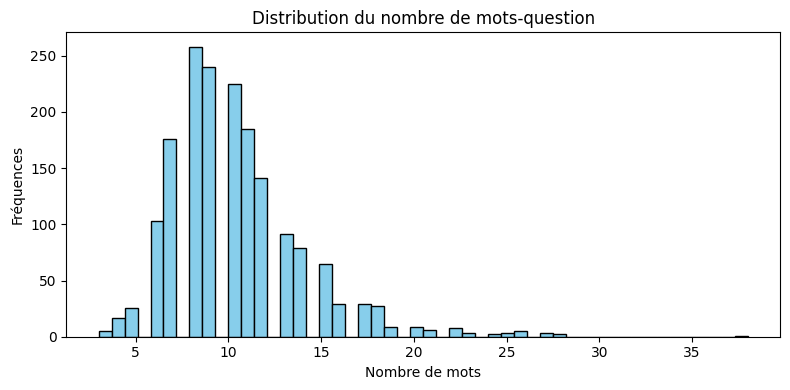

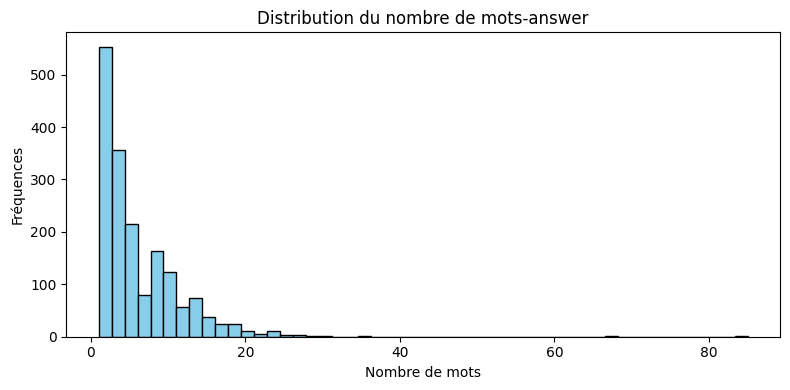

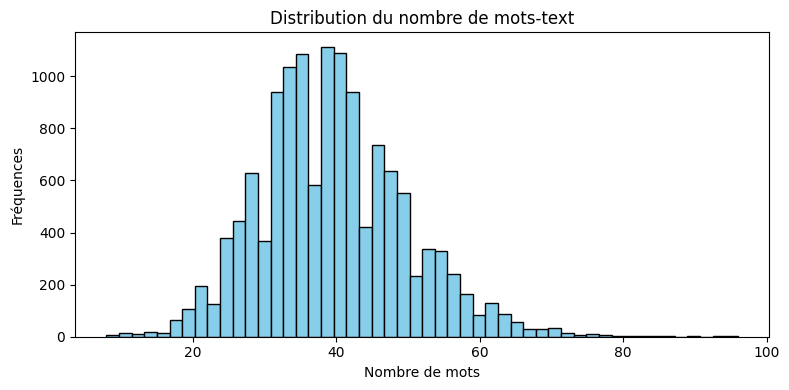

In [ ]:
# TODO
def show_histogram_nb_words(dataset, column):
    count = dataset[column].apply(lambda x: len(x.split()))
    plt.figure(figsize=(8, 4))
    plt.hist(count, bins=50, color='skyblue', edgecolor='black')
    plt.ylabel('Fréquences')
    plt.xlabel('Nombre de mots')
    plt.title(f'Distribution du nombre de mots-{column}')
    plt.tight_layout()


show_histogram_nb_words(train_dataset, 'question')
show_histogram_nb_words(train_dataset, 'answer')
show_histogram_nb_words(texts_dataset, 'text')
# END TODO

## **Analyses**
Pour les deux premiers graphiques, les distribution de mots ne suive pas un loi normal. On observe une asymétrie vers la droite dans la distribution du nombre de mots
dans les questions et les réponses. Cela indique que ces dernières tendent vers des phrases plus courtes. Cela est particulièrement vrai pour le nombre de mots dans
les réponses, pour lesquelles l'asymétrie est encore plus importante que pour le nombre de mots dans les questions. En effet, pour les questions on retrouve un nombre moyen
de mots d'environ 10 et pour les réponse un nombre de mots moyen de 6. Pour le troisième graphique, on observe que la distribution du nombre de mots dans les textes
ressemble à une loi normale.


### 2.2. Chargement du modèle et génération des réponses (5 points)

Nous allons maintenant évaluer la performance d'un modèle de langue à répondre aux questions de l'ensemble de validation. Chargez d'abord le modèle **'microsoft/Phi-3-mini-128k-instruct'** avec la librairie `transformers` de huggingface et générez les réponses du modèle à partir de la question. Générez au maximum 32 nouveaux jetons.

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Chargement du model microsoft/Phi-3-mini-128k-instruct
model_name = 'microsoft/Phi-3-mini-128k-instruct'
model_kwargs = dict(
    torch_dtype="auto",
    device_map=DEVICE,
    trust_remote_code=True,
    )

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, **model_kwargs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.48k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [ ]:
BATCH_SIZE=32
# Création du format pour le prompting et application de celui-ci
def prompt(question):
    prompt = f"""Answer the following question concisely : \n{question}"""
    return tokenizer.apply_chat_template([{'role':'user','content':prompt}], tokenize=False, add_generation_prompt=True)

# Génération des résultats pour avec le model microsoft/Phi-3-mini-128k-instruct
questions = val_dataset['question']
generations = []

model.eval()
with torch.no_grad():
    for i in tqdm(range(0, len(questions), BATCH_SIZE)):
        batch_questions = questions[i:i + BATCH_SIZE]
        batch_prompts = [prompt(q) for q in batch_questions]

        batch_tokenized = tokenizer(batch_prompts, padding=True, return_tensors='pt').to(DEVICE)
        output = model.generate(**batch_tokenized, max_new_tokens=32)
        batch_answers = tokenizer.batch_decode(output[:, batch_tokenized['input_ids'].shape[1]:],skip_special_tokens=True)
        generations.append(batch_answers)

  0%|          | 0/16 [00:00<?, ?it/s]The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
100%|██████████| 16/16 [03:01<00:00, 11.36s/it]


In [ ]:
# Exemple pour les réponses générées
answers = []
for a in generations:
  answers.extend(a)

df_pred = pd.DataFrame(answers)
df_pred.columns = ['answer']

df_pred

,answer
0,The M201V variant of CYSLTR2 reduces responsiv...
1,Carbapenems have a different core structure wi...
2,Two types of facets: 8-demicubes and 8-orthopl...
3,5F-AMB is a synthetic cannabinoid that is not ...
4,Estrone
...,...
495,Inhalation
496,The shape of the cavity or organ found in vari...
497,The closest approach distance of the Pluto Kui...
498,Warm compresses and eyelid massage to improve ...


### 2.3. Évaluation des réponses (3 points)

Complétez la fonction `evaluate_bleu` et utilisez la métrique BLEU pour évaluer les réponses générées par rapport aux réponses attendues sur le jeu de validation. Évaluez votre modèle avec les métriques BLEU-1 et BLEU-2. BLEU-1 ne considère que les unigrammes pour évaluer la réponse et BLEU-2 considère les bigrammes aussi. Pour séparer une séquence en mots, vous pouvez simplement utiliser la fonction `split()`.

In [36]:
def evaluate_bleu(df_true: pd.DataFrame, df_pred: pd.DataFrame, bleu_type: int):
    """
    Évalue les réponses générées en utilisant la métrique BLEU.

    Paramètres:
    df_true (pd.DataFrame): DataFrame contenant les vraies réponses avec des colonnes 'id' et 'answer'.
    df_pred (pd.DataFrame): DataFrame contenant les réponses prédites avec des colonnes 'id' et 'answer'.
    bleu_type (int): Nombre (soit 1 ou 2) correspondant aux n-grammes considérés pour la métrique (bleu_type = 1 : BLEU-1, bleu_type = 2 : BLEU-2)

    Retourne:
    float: Score BLEU moyen sur toutes les entrées.
    """
    # TODO

    # Assignation du type d'évaluation BLEU
    weights = [0] * 4
    weights[:bleu_type] = [1 / bleu_type] * bleu_type

    prediction = df_pred['answer'].apply(lambda x : x.split())
    ground_truth = df_true['answer'].apply(lambda x : x.split())

    blue_scores = [sentence_bleu([truth], pred, weights) for pred, truth in zip(prediction, ground_truth)]

    return np.mean(blue_scores)
    # END TODO

In [ ]:
# TODO
df_true = val_dataset[['id', 'answer']]

print('BLEU-1 :',evaluate_bleu(df_true, df_pred, bleu_type=1))
print('BLEU-2 :',evaluate_bleu(df_true, df_pred, bleu_type=2))
# END TODO

BLEU-1 : 0.18302024340731202
BLEU-2 : 0.07981927089078279


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

### 2.4. Commentaire (2 points)

Reportez, puis commentez la performance obtenue ici.

## **Analyses**
Lors de l'évaluation de nos réponses générées, nous obtenons une valeur de 0,183 pour BLEU-1 et de 0,080 pour BLEU-2. Cela ne représente pas de très bons
résultats pour cette métrique, considérant que les valeurs  peuvent prendre une valeur maximal de 1. Ainsi, il est possible de conclure qu'en se basant uniquement
sur les connaissance du modèle pré entrainé sans fournir aucune informations supplémentaires (passages pertinants), que les réponses générées ne sont pas de bonne
qualité. Considérant que BLEU-1 ne considère que les unigrammes pour évaluer la réponse et BLEU-2 considère aussi les bigrammes il est normale d'observer une diminution de la valeur.

## 3. Approche RAG figé (45 points)

Dans cette partie, vous allez implémenter une approche simple de RAG figé. On dit ici que le modèle est figé car on ne ré-entraîne aucun modèle. Vous implémenterez deux variantes : avec ou sans l'utilisation d'un algorithme d'indexation.

Dans la méthode d'implémentation du RAG figé, vous allez d'abord retrouver les passages pertinents pour chaque question avec un modèle de plongements de type Transformers, puis générer une réponse conditionnée par ces passages.

Dans cette partie, on utilisera
- le modèle de plongements (embedding-model) **[BAAI/bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5)** pour obtenir les vecteur de plongements des questions et des passages
- le modèle de génération (generative-model) **[microsoft/Phi-3-mini-128k-instruct](https://huggingface.co/microsoft/Phi-3-mini-128k-instruct)** pour générer les réponses

### 3.1 RAG figé sans indexation (23 points)

#### 3.1.1 Passages pertinents (8 points)

Pour retrouver les passages pertinents, vous devez d'abord encoder les questions et les passages avec le modèle de plongements. Puis, vous devez calculer la similarité cosinus entre les questions et les passages pour retrouver les $k$ passages les plus pertinents pour chaque question.

In [ ]:
# TODO
model_kwargs = dict(
    use_cache=True,
    torch_dtype="auto",
    device_map= DEVICE,
    trust_remote_code=True,
)

# Chargement du modèle de plongements
embedding_model_name = "BAAI/bge-small-en-v1.5"
embedding_model_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embedding_model = AutoModel.from_pretrained(embedding_model_name,**model_kwargs)

# Utilisation du modèle de génération
generative_tokenizer = tokenizer
generative_model = model
# END TODO

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

In [ ]:
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def encode_sequences(sequences: list, tokenizer, model, device = DEVICE, batch_size = BATCH_SIZE):
    """
    Encode les textes en utilisant le modèle passé en paramètre pour générer les plongements des textes

    Paramètres:
    sequences    : Liste de séquence à transformer en plongements
    tokenizer   : Segmenteur du modèle de plongements
    model       : Modèle de plongements
    device      : Machine sur laquelle les opérations doivent être effectuées
    batch_size  : Taille des lots lors de la génération des traitements
    """

    # TODO
    model.to(device)
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(sequences), batch_size)):
            batch = sequences[i:i + batch_size]
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
            outputs = model(**inputs)
            embeddings = outputs[0][:, 0].to(device)

            all_embeddings.append(embeddings)

    return torch.cat(all_embeddings)


def cosine_similarity(a, b, dim):
    return torch.nn.functional.cosine_similarity(a, b, dim=dim)

    # END TODO

#### 3.1.2 Évaluation des passages retrouvés avec Recall@k et precision@k (7 points)

Maintenant que les passages ont tous été encodés, on peut évaluer si les passages retrouvés sont pertinents. En prenant les $k$ premiers passages, on peut évaluer si on retrouve les bons passages associés aux questions. C'est un des avantages du système RAG : on peut évaluer de façon indépendante la qualité du système qui retrouve les passages pertinents et de celui qui génère les réponses. Cela permet notamment d'évaluer quels sont les points forts et points faibles du système.

Pour cela, vous allez utiliser les métriques **Precision@k** et **Recall@k** définies dans les équations suivantes. Implémentez ces métriques.

$$\text{Precision@k} = \frac{\text{Nombre d'éléments pertinents dans les k premiers}}{k}$$

$$\text{Recall@k} (Rappel@k) = \frac{\text{Nombre d'éléments pertinents dans les k premiers}}{\text{Nombre total d'éléments pertinents}}$$


In [18]:
def compute_recall_at_k(ground_truth, predictions):
    """
    Calcule la métrique du "Recall@k". On assume que predictions contiennent le bon nombre de passages (=k)

    Paramètres:
    ground_truth : Liste contenant tous les vrais passages associés aux questions (ex : [[1, 2, 3], [4, 5, 6]] si les passages de la question 1 sont [1, 2, 3] et
    les passages de la question 2 sont [4, 5, 6])
    predictions : Liste contenant tous les passages retrouvés pour chacune des questions formattée de la même manière que `ground_truth`

    Retourne:
    Recall moyen
    """
    # TODO
    recall = [len(set(gt) & set(pred))/len(gt) for gt, pred in zip(ground_truth, predictions)]
    return np.mean(recall)
    # END TODO

In [19]:
def compute_precision_at_k(ground_truth, predictions):
    """
    Calcule la métrique du "Precision@k". On assume que predictions contiennent le bon nombre de passages (=k)

    Paramètres:
    ground_truth : Liste contenant tous les vrais passages associés aux questions (ex : [[1, 2, 3], [4, 5, 6]] si les passages de la question 1 sont [1, 2, 3] et
    les passages de la question 2 sont [4, 5, 6])
    predictions : Liste contenant tous les passages retrouvés pour chacune des questions formattée de la même manière que `ground_truth`

    Retourne:
    Précision moyenne
    """
    # TODO
    precision = [len(set(gt) & set(pred))/len(pred) for gt, pred in zip(ground_truth, predictions)]
    return np.mean(precision)
    # END TODO

#### 3.1.3 Résultat d'évaluation (5 points)
Implémentez la fonction _'retrieve_passages'_ qui retourne les indices des $k$ passages les plus similaires pour une question. Utilisez la similarité cosinus pour comparer les passages et les questions. Évaluez ensuite votre modèle récupérant les passages avec les métriques Precision@k et Recall@k sur le jeu de validation. Calculez avec $k={1, 2, 3, 4, 5}$.

In [ ]:
def retrieve_passages(questions: list, passage_embed: torch.Tensor, k: int, embedding_model_tokenizer, embedding_model):
    """
    Retourne les k passages les plus pertinents pour chaque question passée en paramètre

    Paramètres:
    questions       : Les questions pour lesquelles on cherche les passages les plus pertinents
    passage_embed   : Tenseur contenant les plongements de chaque passage (n, dim)
    k               : le nombre de passages à retourner
    tokenizer       : Segmenteur du modèle de plongements
    model           : Modèle de plongements

    Retourne:
    Les indices des k passages les plus pertinents pour la question
    """
    # TODO

    # Création de plongements pour chaque question
    question_embeddings = encode_sequences(questions, embedding_model_tokenizer, embedding_model)

    batch_size = BATCH_SIZE
    all_similarities = []
    embedding_model.eval()

  # calculer la similarité entre les questions et les passages et trouvé les top k passages pertinants
    with torch.no_grad():
        for i in tqdm(range(0, question_embeddings.shape[0], batch_size)):
          with torch.no_grad():
            question_batch_embeddings = question_embeddings[i:i + batch_size]
            similarities = cosine_similarity(question_batch_embeddings.unsqueeze(1), passage_embed.unsqueeze(0), 2)
            all_similarities.append(similarities)
    all_similarities = torch.cat(all_similarities)
    relevant_passages_topk = torch.topk(all_similarities, k)

    return relevant_passages_topk.indices.tolist()
    # END TODO

In [ ]:
# TODO
questions = val_dataset['question'].tolist()
passages = texts_dataset['text'].tolist()

passage_embeddings = encode_sequences(passages, embedding_model_tokenizer, embedding_model, device=DEVICE, batch_size=BATCH_SIZE)
# END TODO

100%|██████████| 833/833 [00:21<00:00, 39.13it/s]


In [ ]:
# TODO
recall = []
precision = []
ground_truth = val_dataset['text_ids'].apply(lambda x: [int(num) for num in re.findall(r'\d+', x)]).tolist()

# Récuper les top k passages pertinants et calculer la précision et le rappel
for k in range(1,6):
    relevant_passages_topk = retrieve_passages(questions, passage_embeddings, k, embedding_model_tokenizer, embedding_model)

    recall.append(compute_recall_at_k(ground_truth, relevant_passages_topk))
    precision.append(compute_precision_at_k(ground_truth, relevant_passages_topk))

    print(f"Recall@{k}: ", recall[-1])
    print(f"Precision@{k}: ", precision[-1])
    print(f"F1-score@{k}: ", (2*precision[-1]*recall[-1])/(precision[-1]+recall[-1]))
# END TODO

100%|██████████| 32/32 [00:00<00:00, 4502.14it/s]


Recall@1:  0.3328333333333333
Precision@1:  0.89
F1-score@1:  0.4844841215755758


100%|██████████| 32/32 [00:00<00:00, 4460.39it/s]


Recall@2:  0.49333333333333323
Precision@2:  0.675
F1-score@2:  0.5700427960057062


100%|██████████| 32/32 [00:00<00:00, 4223.07it/s]


Recall@3:  0.6031666666666666
Precision@3:  0.5593333333333333
F1-score@3:  0.5804236081242532


100%|██████████| 32/32 [00:00<00:00, 3477.50it/s]


Recall@4:  0.7046666666666667
Precision@4:  0.4955
F1-score@4:  0.5818564088321068


100%|██████████| 32/32 [00:00<00:00, 3489.80it/s]


Recall@5:  0.7751666666666668
Precision@5:  0.4384
F1-score@5:  0.5600566923943198


#### 3.1.4 Graphique (3 points)
Affichez maintenant un graphique de vos résultats de la question précédente en mettant à l'axe des x la valeur de $k$ et à l'axe des y la valeur de la précision et du rappel. Quel est le nombre optimal de passages à passer au modèle en vous basant sur le recall@k et precision@k ? Pourquoi ?

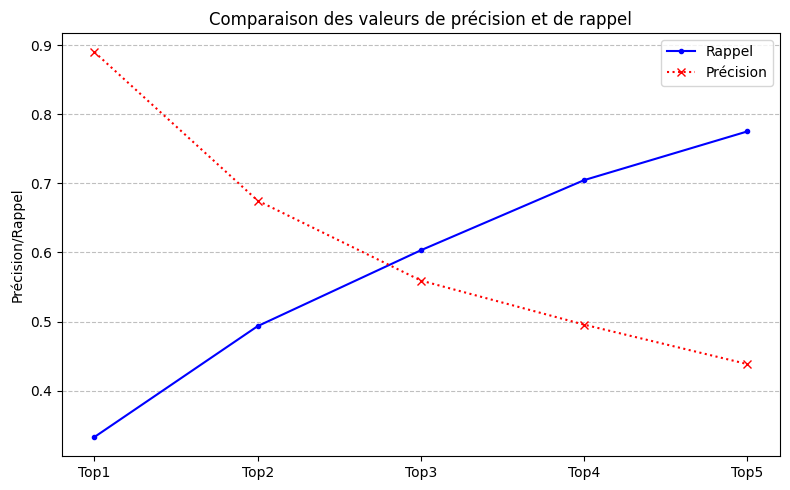

In [ ]:
# TODO
top_n = range(1,6)
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(top_n, recall, marker='.', color='blue', linestyle='-', label="Rappel")
ax.plot(top_n, precision, marker='x', color='red', linestyle=':', label="Précision")

ax.set_ylabel('Précision/Rappel')
ax.set_title('Comparaison des valeurs de précision et de rappel')
ax.set_xticks(top_n)
ax.set_xticklabels([f'Top{k}' for k in range(1,6)])
ax.legend(loc='best')
ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()
# END TODO

## **Analyses**
Le nombre de passages optimal à passer au modèle est 4. Considérant que dans notre cas, nous souhaitons autant maximiser
le rappel que la précision. Nous avons décidé de calculer le score F1 afin de déteminer quel valeur de k est optimal.
Ainsi, c'est k=4 avec un score F1 de 0.582 qui est le plus élevé parmi les valeurs de k testées. Ce choix de k est cohérant
avec notre graphique obtenu, puisqu'on remarque que les valeurs de rappel et précision commence un peu à plafonner à partir
de k=4 (augmente/diminue moins rapidement).

### 3.2 RAG figé avec FAISS (14 points)

Maintenant on vous demande d'utiliser FAISS pour l'indexation des plongements des passages.

[FAISS (Facebook AI Similarity Search)](https://ai.meta.com/tools/faiss/) est une bibliothèque open-source développée par Meta pour la recherche de similarité rapide sur des vecteurs denses, comme des embeddings de textes ou d'images. Elle est optimisée pour gérer de grands volumes de données en haute dimension et peut être accélérée avec des GPU. FAISS est largement utilisée pour des systèmes de recommandation ou la recherche d'information à grande échelle. Pour plus de détails, veuillez consulter  [le tutoriel sur Moodle](https://moodle.polymtl.ca/course/view.php?id=2813).


#### 3.2.1 Initialisez l'indexation FAISS avec les plongements des passages (2 points)

Utilisez les plongements des passages générés au niveau de la question 3.1.1 et indexez-les avec FAISS. Vérifiez que le nombre de plongements dans l'objet FAISS est bien le même que le nombre de passages. N'oubliez pas qu'on veut une indexation basée sur la similarité cosinus.

In [ ]:
# TODO
passage_embeddings_np = np.array(passage_embeddings.to('cpu'), dtype=np.float32)
faiss.normalize_L2(passage_embeddings_np)
passage_index = faiss.IndexFlatL2(passage_embeddings_np.shape[1])
passage_index.add(passage_embeddings_np)

print(f"Nombre de plongements dans l'index : {passage_index.ntotal}")
print(f"Nombre de passages : {passage_embeddings_np.shape[0]}")
# END TODO

Nombre de plongements dans l'index : 13314
Nombre de passages : 13314


#### 3.2.2 Récupération des passages avec FAISS (4 points)

Implémentez la fonction _'retrieve_passages_faiss'_ qui retourne les indices des $k$ passages les plus similaires pour une question à l'aide d'un indexation FAISS


In [16]:
def retrieve_passages_faiss(questions: list, vector_index: faiss.IndexFlatL2, k: int, embedding_model_tokenizer, embedding_model):
    """
    Retourne les k passages les plus pertinents pour chaque question passée en paramètre

    Paramètres:
    questions       : Les questions pour lesquelles on cherche les passages les plus pertinents
    vector_index    : L'objet d'indexation FAISS
    k               : le nombre de passages à retourner
    tokenizer       : Segmenteur du modèle de plongements
    model           : Modèle de plongements

    Retourne:
    Les indices des k passages les plus pertinents pour la question
    """
    # TODO
    question_embeddings = encode_sequences(questions, embedding_model_tokenizer, embedding_model)
    question_embeddings_np = np.array(question_embeddings.to('cpu'), dtype=np.float32)
    faiss.normalize_L2(question_embeddings_np)

    distances, indices = vector_index.search(question_embeddings_np, k)

    return indices
    # END TODO

#### 3.2.3 Exécution de FAISS (4 points)

Exécutez maintenant la fonction _"retrieve_passages_faiss"_ pour récupérer les bons passages pour les questions du jeu de validation avec votre k optimal.

In [ ]:
# TODO
questions = val_dataset['question'].tolist()
k = 4
relevant_passages_topk_faiss = retrieve_passages_faiss(questions, passage_index, k, embedding_model_tokenizer, embedding_model)
# END TODO

100%|██████████| 32/32 [00:00<00:00, 85.28it/s]


In [ ]:
# test example
relevant_passages_topk_faiss

array([[10039,  1885,  4270, 13215],
       [ 8865,  5333,  2651, 10220],
       [11620,  4618, 10382,  6488],
       ...,
       [ 2838,  1001,  7523,   513],
       [10021, 13016,  4295, 11171],
       [ 1728,  5978,  6130,  2595]])

#### 3.2.4 Calculez les métriques Precision@K et Rappel@K pour les passages retrouvés avec FAISS avec votre k optimal (2 points)

In [ ]:
ground_truth = val_dataset['text_ids'].apply(lambda x: [int(num) for num in re.findall(r'\d+', x)]).tolist()
print(f"Recall@{k}: ", compute_recall_at_k(ground_truth, relevant_passages_topk_faiss))
print(f"Precision@{k}: ", compute_precision_at_k(ground_truth, relevant_passages_topk_faiss))

Recall@4:  0.7046666666666667
Precision@4:  0.4955


#### 3.2.5 Quelle remarque pouvez-vous faire sur l'utilisation de FAISS en termes de passages retrouvés, de temps d'exécution et de tout autre élément qui vous semble approprié ? (2 points)

## **Analyses**
L'utilisation de FAISS ne modifie pas des passages retrouvés par le modèle. En effet, avec ou sans l'utilisation de FAISS, on obtient les mêmes valeurs de rappel
et de précision, soit 0,705 pour le rappel et 0,496 pour la précision lorsque k=4. Toutefois, FAISS permet d'améliorer le temps d'exécution du modèle. En effet,
FAISS a été conçu pour gérer efficacement des modèles de grande taille en utilisant la technique "clustering of dense vectors". Il est donc capable de réaliser des recherches rapidement sans toutefois compromettre la qualité des
résultats obtenus. De plus, l'utilisation FAISS permet de diminuer la quantité de mémoire utilisé en permettant de compresser les vecteurs stocker.

### 3.3 Génération des réponses (5 points)

Générez maintenant les réponses des questions sur l'ensemble de validation avec les passages récupérés. Pour générer les réponses, vous devez concaténer les passages pertinents avec la question et donner le tout au modèle de génération. Faites-le sur l'ensemble du jeu de validation. Pour la méthode, vous avez le choix entre les passages retrouvés avec FAISS ou manuellement (avec votre propre implémentation). Faites cela pour toutes les valeurs de $k$: (1, 2, 3 et 4).

In [28]:
# Création du format pour le prompting et application de celui-ci
def prompt(passage, question):
    prompt = f"""Answer the following question concisely using the context below\n Context : {passage}\n Question : {question}\n Answer :"""
    return generative_tokenizer.apply_chat_template([{'role':'user','content':prompt}], tokenize=False, add_generation_prompt=True)

# Génération des prompts
def generate_prompts(questions, passage_index, k, passages, embedding_model_tokenizer, embedding_model):
    relevant_passages_topk_faiss = retrieve_passages_faiss(questions, passage_index, k, embedding_model_tokenizer, embedding_model)
    prompts = []
    for i in range(len(questions)):
        relevant_passage = [passages[j] for j in relevant_passages_topk_faiss[i]]
        relevant_txt = ' '.join(relevant_passage)
        prompts.append(prompt(relevant_txt, questions[i]))
    return prompts

Affichez un exemple d'invite (prompt) qui sera envoyé au modèle de génération

In [ ]:
# TODO
# Affichez un exemple d'invite
k = 4
questions = val_dataset['question'].tolist()
prompts = generate_prompts(questions[:2], passage_index, k, passages, embedding_model_tokenizer, embedding_model)
prompts
# END TODO

100%|██████████| 1/1 [00:00<00:00, 54.01it/s]


['<|user|>\nAnswer the following question concisely using the context below\n Context :  Polymorphism in the CYSLTR2 gene has been associated with the inheritance of asthma in separate populations. The M201V variant of CYSLTR2 exhibits decreased responsiveness to LTD4, suggesting that this hypo-responsiveness underlies its asthma transmission-protecting effect.  Cysteinyl leukotriene receptor 2 (CYSLTR2) is a receptor that binds to cysteinyl leukotrienes (CysLTs) and contributes to mediating allergic and hypersensitivity reactions in humans. It is expressed in various cell types, including blood eosinophils, platelets, and tissue mast cells.  The human CYSLTR2 gene maps to chromosome 13 and consists of four exons. The protein encoded by CYSLTR2 is composed of 347 amino acids and shares only 31% amino acid identity with the CysLTR1 protein. CYSLTR2 is a G protein-coupled receptor that activates the Gq alpha subunit and/or Ga subunit of its coupled G protein when bound to its CysLT ligan

In [24]:
# TODO
BATCH_SIZE=8

# Générez les réponses des questions sur l'ensemble de validation avec les passages récupérés
def generate_answers_with_passage(k, embedding_model=embedding_model, generative_model=generative_model, max_new_tokens=32, questions = questions):
    generations = []
    generative_model.eval()

    for i in tqdm(range(0, len(questions), BATCH_SIZE)):
        with torch.no_grad():
            batch_questions = questions[i:i + BATCH_SIZE]
            batch_prompts = generate_prompts(batch_questions, passage_index, k, passages, embedding_model_tokenizer, embedding_model)
            batch_tokenized = generative_tokenizer(batch_prompts, padding=True, return_tensors='pt').to(DEVICE)
            output = generative_model.generate(**batch_tokenized, max_new_tokens=32)
            batch_answers = generative_tokenizer.batch_decode(output[:, batch_tokenized['input_ids'].shape[1]:],skip_special_tokens=True)
            generations.append(batch_answers)

    answers = []
    for a in generations:
        answers.extend(a)

    df_pred = pd.DataFrame(answers)
    df_pred.columns = ['answer']

    return df_pred
# END TODO

In [ ]:
df_pred_1 = generate_answers_with_passage(1)

100%|██████████| 63/63 [10:53<00:00, 10.38s/it]


In [ ]:
df_pred_2 = generate_answers_with_passage(2)

100%|██████████| 63/63 [13:35<00:00, 12.95s/it]


In [ ]:
df_pred_3 = generate_answers_with_passage(3)

100%|██████████| 63/63 [16:00<00:00, 15.24s/it]


In [ ]:
df_pred_4 = generate_answers_with_passage(4)

100%|██████████| 63/63 [19:18<00:00, 18.38s/it]


### 3.4 Évaluation des réponses (3 points)

Utilisez la métrique BLEU (BLEU-1 et BLEU-2) pour évaluer les réponses générées par rapport aux réponses attendues sur le jeu de validation.

In [ ]:
# TODO
def evaluate_generations(df_pred, k):
    print(f'k={k}')
    df_true = val_dataset[['id', 'answer']]
    print('BLEU-1 :',evaluate_bleu(df_true, df_pred, bleu_type=1))
    print('BLEU-2 :',evaluate_bleu(df_true, df_pred, bleu_type=2))
# END TODO

In [ ]:
evaluate_generations(df_pred_1, 1)

k=1
BLEU-1 : 0.5846573524583661
BLEU-2 : 0.43153255942475766


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
evaluate_generations(df_pred_2, 2)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

k=2
BLEU-1 : 0.6099555345427039
BLEU-2 : 0.4619156731004056


In [ ]:
evaluate_generations(df_pred_3, 3)

k=3


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU-1 : 0.6192631028260305
BLEU-2 : 0.4670018160511024


In [ ]:
evaluate_generations(df_pred_4, 4)

k=4
BLEU-1 : 0.6233207145935108
BLEU-2 : 0.4717526272760978


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

En vous basant sur les résultats de génération du modèle sur l'ensemble de validation, quel est le nombre optimal de passages à passer au modèle ? Qu'en concluez-vous par rapport au nombre optimal de passages trouvé à la question 3.1.4 ?

## **Analyses**
En se basant sur les résultats obtenus avec les métriques BLEU-1 et BLEU-2 le nombre de passages obtimal est de 4. En effet, c'est avec cette valeur qu'on
obtient les meilleurs valeurs pour BLEU-1 avec 0.623 et BLEU-2 avec 0.472. Ceci correspond à la valeur optimal trouvé en 3.1.4 qui était de 4.  Ceci est
logique, car en passant plus de passage on a plus de chance de choisir des passages pertinants pour généré la réponse.

### 3.5 Test de soumission Kaggle
Faites également une soumission Kaggle de votre modèle RAG sur le fichier de test et reportez la valeur obtenue ici.


In [ ]:
questions = test_dataset['question'].tolist()
df_pred_test = generate_answers_with_passage(4)
df_pred_test.insert(0, 'id', test_dataset['id'])
df_pred_test.to_csv(root_path + '3.5-Test de soumission Kaggle.csv', index=False)

100%|██████████| 63/63 [19:02<00:00, 18.13s/it]


In [ ]:
print('Soumission Kaggle sur le fichier de test (k = 4) : 0.39417', '\n')

df_pred_test

Soumission Kaggle sur le fichier de test (k = 4) : 0.39417 



,id,answer
0,792,An expectorant
1,507,Fungi and some red algae
2,1409,Chromosome 19
3,1369,Surface photometry
4,1198,201 amino acids
...,...,...
495,1743,LMP2B
496,420,n is even and n ≥ 2
497,1013,Scutum
498,419,The graph must be directed and acyclic.


## 4. Compétition Kaggle (40 points)

Dans cette partie, vous devez implémenter votre propre méthode pour répondre aux questions. Pour rappel, vous ne pouvez pas utiliser de données externes pour entraîner vos modèles, seulement les données fournies, et vous devez utiliser le modèle de génération **'microsoft/Phi-3-mini-128k-instruct'**.

Proposez une architecture plus complexe, ou améliorez les modèles des parties précédentes, afin d’obtenir un score plus élevé que vos autres modèles sur l’ensemble de validation ET dans la compétition Kaggle. Démontrez bien cette amélioration dans votre notebook dans les cellules suivantes. Un autre objectif est d'obtenir le meilleur score de la classe.

Vous devez commencer cette démarche par un état de l'art.

### 4.1. État de l'art (5 points)

Décrivez en **deux paragraphes**, dans une cellule du notebook, avec les références appropriées, les approches de l’état de l’art pour la tâche que vous tentez d'accomplir. Utilisez une recherche dans Google Scholar.

En vous basant sur vos recherches, quelles sont les meilleures techniques de l’état de l’art ?  Soyez brefs et clairs. Attention, on ne vous demande pas les détails d'un papier particulier mais une synthèse des meilleures approches de l'état de l'art.

## **Synthèse**
### **- Recherche d'information(RAG)**
Au niveau de la tâche de la recherche d'information du processus de RAG, on retrouve plusieurs techniques d'approche contrastive comme DPR, Contriever et HyDE, qui permettent d'obtenir de très bons résultats. L'approche contrastive consiste à apprendre au modèle à encoder les éléments ayant des relations (paires positives) proches les uns des autres dans l'espace vectoriel et les éléments n'ayant pas de relation (paires négatives) loin les uns des autres dans l'espace vectoriel. De manière générale, ces techniques sont capables d'obtenir de meilleurs ou aussi bons résultats que BM25. Malgré leurs performances moins bonnes que les techniques d'approche contrastive, les techniques de recherche creuse comme BM25 restent encore très d'actualité. Cette technique, plus simple que les techniques d'approche contrastive, permet d'obtenir quand même d'excellents résultats de base. Ainsi, celle-ci est souvent utilisée comme point de comparaison pour d'autres techniques développées dans le domaine de la recherche d'information. Les techniques de recherche creuse se basent sur le principe de transformer les requêtes et documents en vecteurs creux de fréquences de mots afin de calculer un score indiquant la pertinence d'un document par rapport à la requête. Les architectures de type bi-encodeur et cross-encodeur sont aussi souvent présentes dans la littérature. L'architecture bi-encodeur utilise deux encodeurs différents, un pour encoder les requêtes et l'autre pour encoder les documents. Le modèle tente ensuite de maximiser la similarité entre les requêtes et les documents pertinents tout en minimisant la similarité entre les requêtes et les documents non pertinents. Pour sa part, l'architecture cross-encodeur traite les requêtes et documents dans le même encodeur pour générer une représentation conjointe des éléments, puisqu’on n'en retrouve qu'un dans ce type d'architecture. L'objectif de l'architecture cross-encodeur est, comme celle du bi-encodeur, de maximiser la similarité entre les paires requêtes-documents. Toutefois, l'utilisation d'un seul encodeur permet à ce type d'architecture d'être capable de capturer également l'interactivité existante entre les requêtes et les documents. Finalement, le Self-RAG est une technique assez récente qui consiste en la combinaison du processus de RAG avec le processus de self-réflexion. Ainsi, le modèle itère sur lui-même afin d'évaluer les requêtes qu'il génère à l'aide de jetons de réflexion (jetons de recherche et jetons de critique) pour lui permettre de mieux reformuler ses requêtes. Ceci permet au modèle d'être capable de générer de meilleures requêtes et ainsi d'améliorer la qualité des informations qu'il récupère par le processus de RAG et des réponses qu'il génère. Cette technique offre d'excellents résultats.

### **- Ajustements efficaces LLM**
Il existe de nombreuses techniques de PEFT, qui permettent d’ajuster les modèles, plus particulièrement les modèles génératifs, à des tâches spécifiques. Ces techniques reposent sur le principe de modifier uniquement une partie des poids du modèle plutôt que tous les poids pour adapter le modèle à la tâche souhaitée. Il s'agit d'un sujet de recherche d'actualité très vaste. Parmi les méthodes les plus performantes de l'actualité scientifique, on retrouve Adapter, BitFit et QLoRA. La méthode Adapter fonctionne en ajoutant des paramètres supplémentaires entre les couches d’un modèle. Seuls ces paramètres seront mis à jour alors que les paramètres du modèle préentraîné resteront gelés. La méthode BitFit, de sa part, vient seulement affiner les termes de biais du modèle et la couche de classification spécifique à la tâche. Contrairement à Adapter, BitFit ne modifie l’architecture du modèle. Finalement, QLoRA, une des techniques les plus récentes, fait la quantification du modèle sur 4 bits avant d’utiliser LoRA pour l’entraîner. LoRA ajoute des matrices de poids qui sont ajustées pour une tâche spécifique au modèle déjà pré-entraîné. Comme BitFit, QLoRA ne modifie l’architecture du modèle.

## **Références**
1. Karpukhin, V., Oğuz, B., Min, S., Lewis, P., Wu, L., Edunov, S., ... & Yih, W. T. (2020). Dense passage retrieval for open-domain question answering. arXiv preprint arXiv:2004.04906.

2. Gao, L., Ma, X., Lin, J., & Callan, J. (2022). Precise zero-shot dense retrieval without relevance labels. arXiv preprint arXiv:2212.10496.

3. Izacard, G., Caron, M., Hosseini, L., Riedel, S., Bojanowski, P., Joulin, A., & Grave, E. (2021). Unsupervised dense information retrieval with contrastive learning. arXiv preprint arXiv:2112.09118.

3. Asai, A., Wu, Z., Wang, Y., Sil, A., & Hajishirzi, H. (2023). Self-rag: Learning to retrieve, generate, and critique through self-reflection. arXiv preprint arXiv:2310.11511.

4. Dettmers, T., Pagnoni, A., Holtzman, A., & Zettlemoyer, L. (2024). Qlora: Efficient finetuning of quantized llms. Advances in Neural Information Processing Systems, 36.

### 4.2. Description de votre méthode (5 points)

Décrivez en deux paragraphes l'architecture proposée en soulignant notamment les additions ou l'originalité de l'approche et comment l'état de l'art l'a inspirée

●	Le RAG implémenté dans notre méthode décompose la tâche de réponse aux questions en utilisant deux modèles : Un modèle de recherche, notamment "BAAI/bge-small-en-v1.5" pour l’encodage des documents et questions et récupération des passages pertinents, puis un modèle génératif 'microsoft/Phi-3-mini-128k-instruct' qui lit la question et les passages retrouvés pour répondre à la question. Pour le modèle de recherche, notre méthode s’inspire de la méthode de l’état de l’art ‘DPR’ (Dense passage retrieval) dans le sens où elle utilise une architecture bi-encodeur où les documents et les questions sont encodés indépendamment avec le même modèle. Cependant, la construction de l'ensemble d'entraînement ait construit de la manière suivante : les exemples positifs sont tirés des passages pertinents indiqués au niveau des données. De l’autre côté, les documents négatifs durs sont tirés des BM25 top-2, après avoir retiré les documents pertinents y figurant. D’autres négatifs sont générés en utilisant 7 documents pertinents à d’autres questions dans l’ensemble d’entraînement. Chaque entrée de l’ensemble d’entraînement est donc de la forme (question, passages positifs, passages négatifs).  On attribue à chaque paire de question-passage  un label qui prend 1 si le passage est positif et 0 sinon. Lors de l'entraînement, le modèle sélectionne aléatoirement un seul document positif, tandis que les neuf documents négatifs sont conservés. Une modification par rapport à la structure d'origine concerne la fonction objective, où l'entropie croisée est utilisée pour calculer la perte au lieu d’une perte contrastive.

●	Dans la deuxième phase, le modèle de génération est affiné à l'aide de Q-LORA en quantification 4 bits. Les exemples d'ajustement incluent des passages pertinents servant de contexte, ainsi que la question et la réponse correspondante. Plus particulièrement,  le modèle s'appuie sur un pipeline de génération de prompts qui structure les éléments précédents sous forme de conversations, afin de mieux aligner le modèle avec les objectifs de l'entraînement. Cette étape permet d'adapter le modèle à notre tâche spécifique tout en optimisant l'utilisation des ressources et en préservant l'efficacité computationnelle grâce au PEFT.

### 4.3. Implémentation (20 points)

Implémentez votre modèle ci-dessous dans une ou plusieurs cellules (veillez à la qualité de votre code) et effectuez votre soumission sur Kaggle en respectant le format de soumission.

# **Fine-tuning BGE avec DPR**

In [55]:
# Initialisation du modèle de plongements en appliquant la quantisation
embedding_model_name = "BAAI/bge-small-en-v1.5"
embedding_model_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embedding_model = AutoModel.from_pretrained(embedding_model_name,
                                             torch_dtype='auto',
                                             trust_remote_code=True,
                                             quantization_config=BitsAndBytesConfig(load_in_4bit=True),
                                             device_map='auto')

In [56]:
N_negative_passage = 7
N_hard_negative_passage = 2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Tokenisation des passages
tokenized_documents = [word_tokenize(doc.lower()) for doc in texts_dataset['text'].tolist()]
bm25 = BM25Okapi(tokenized_documents)

# Dataset personnalisé pour l'entraînement du modèle embedding
class TrainDatasetForEmbedding():
    def __init__(self, dataset_pos_neg_dict, tokenizer):
        self.dataset = dataset_pos_neg_dict
        self.total_len = len(self.dataset)
        self.tokenizer = tokenizer
    def __len__(self):
        return self.total_len
    def __getitem__(self, item):
        query = self.dataset[item]['query']
        passages = [random.choice(self.dataset[item]['pos'])]
        passages.extend(self.dataset[item]['neg'])
        return query, passages

# Collator personnalisé pour la tokenisation des queries et passages
class EmbedCollator(DataCollatorWithPadding):
    def __call__(self, features):
        query = [f[0] for f in features]
        passage = [f[1] for f in features]
        if isinstance(query[0], list):
            query = sum(query, [])
        if isinstance(passage[0], list):
            passage = sum(passage, [])
        return {"query": self.tokenizer(query,padding=True,truncation=True,max_length=256,return_tensors="pt"),
                "passage": self.tokenizer(passage,padding=True,truncation=True,max_length=256,return_tensors="pt")}

# Fonction pour obtenir des IDs de passages négatifs
def getNegativeids(postive_ids_list, totalPOOL, N_negative_passage=N_negative_passage):
    negative_pool_i = totalPOOL - set(postive_ids_list)
    negatives_ids_list = list(np.random.choice(list(negative_pool_i), N_negative_passage, replace=False))
    return negatives_ids_list

# Fonction pour obtenir des passages négatifs difficiles avec BM25
def getBM25(query, positive_list, tokenized_documents = tokenized_documents, N_hard_negative_passage=N_hard_negative_passage, bm25 = bm25):
    tokenized_query = word_tokenize(query.lower())
    scores = bm25.get_scores(tokenized_query)
    bm25_dict = {i:j for i,j in enumerate(scores)}
    bm25_topK = sorted(bm25_dict.items(), key=lambda item: item[1], reverse=True)[:10]

    bm25_topK_ids = [i[0] for i in bm25_topK]
    hard_negative_list = [i for i in bm25_topK_ids if not i in positive_list]
    return hard_negative_list[:N_hard_negative_passage]

# Encode les textes en utilisant le modèle passé en paramètre pour générer les plongements des textes
def encode_sequences(sequences: list, tokenizer, model, device = DEVICE, batch_size = 16):
    model.to(device)
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(sequences), batch_size)):
            batch = sequences[i:i + batch_size]
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
            try:
                outputs = model(**inputs)
                embeddings = outputs[0][:, 0].to(device)
            except:
                embeddings = model(query = inputs, passage = inputs, trainingMod = False)

            all_embeddings.append(embeddings)

    return torch.cat(all_embeddings)


# Préparation des données d'entraînement
def prepareDataSet(train_val_dataset, N_negative_passage = N_negative_passage, N_hard_negative_passage=N_hard_negative_passage, texts_dataset=texts_dataset, hypo_train_dataset=None):
    # passage dict, passage no. : text
    passage_dict = texts_dataset.set_index('id')['text'].to_dict()

    # id : question str
    qid_str = train_val_dataset.set_index('id')['question'].to_dict()

    if hypo_train_dataset is None:
        train_val_question_dict = train_val_dataset.set_index('id')['question'].to_dict()
    else:
        train_val_question_dict = hypo_train_dataset.set_index('id')['question'].to_dict()

    # question_id : [positive no.]
    train_val_question_positive_dict = train_val_dataset.set_index('id')['text_ids'].to_dict()
    train_val_question_positive_dict = {k: [int(i) for i in v.replace('[', '').replace(']', '').split(' ')] for k, v in train_val_question_positive_dict.items()}

    # passages positifs associés à d'autres questions
    totalPOOL = []
    for k, v in train_val_question_positive_dict.items():
        totalPOOL.extend(v)
    totalPOOL = set(totalPOOL)
    data_out = []
    for key, val in tqdm(train_val_question_positive_dict.items()):
        data_out_i = {"query": 'str', "pos": [], "neg": []}
        data_out_i["query"] = train_val_question_dict[key]
        data_out_i["pos"].extend([passage_dict[po] for po in val])
        negatives_ids_list = getNegativeids(train_val_question_positive_dict[key], totalPOOL)
        data_out_i["neg"].extend([passage_dict[nid] for nid in negatives_ids_list])

        hard_negatives_ids_list = getBM25(qid_str[key], train_val_question_positive_dict[key])
        data_out_i["neg"].extend([passage_dict[nid] for nid in hard_negatives_ids_list])
        data_out.append(data_out_i)

    return data_out

# Génération le dataset d'entraînement avec passages positifs et négatifs
dataset_train_pos_neg_dict = TrainDatasetForEmbedding(prepareDataSet(train_dataset, hypo_train_dataset=None), embedding_model_tokenizer)

100%|██████████| 1747/1747 [01:55<00:00, 15.11it/s]


In [57]:
# Initialisation du modèle BiEncoder
class BiEncoderModel(torch.nn.Module):
    def __init__(self, model_name = embedding_model_name):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.cross_entropy = torch.nn.CrossEntropyLoss(reduction='mean')

    # Encode des features en représentations vectorielles
    def encode(self, features):
        p_reps = self.model(**features).last_hidden_state[:, 0]
        return p_reps.contiguous()

    def forward(self, query, passage, trainingMod = True):
        q_reps = self.encode(query)
        p_reps = self.encode(passage)
        loss = None

        if trainingMod:
            group_size = p_reps.size(0) // q_reps.size(0)
            scores = torch.matmul(q_reps, p_reps.transpose(0, 1))
            target = torch.arange(scores.size(0), device=scores.device, dtype=torch.long)
            target = target * group_size
            loss = self.compute_loss(scores, target)

        return loss if loss is not None else p_reps

    def compute_loss(self, scores, target):
        return self.cross_entropy(scores, target)

class BiTrainer(Trainer):
    # Surcharge la méthode compute_loss pour intégrer une perte personnalisée
    def compute_loss(self, model, inputs, num_items_in_batch=None):
        outputs = model(**inputs, trainingMod = True)
        loss = outputs
        return loss

In [58]:
batch_size = 16
output_dir = data_path + 'result'
model = BiEncoderModel()

# Arguments d'entraînement
training_args = TrainingArguments(
    output_dir=output_dir,
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    num_train_epochs=3,
    logging_steps=50,
    weight_decay=0.01,
    save_total_limit=5,
    report_to=None,
)

# Initialisation du BiTrainer
embedding_trainer = BiTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train_pos_neg_dict,
    data_collator=EmbedCollator(embedding_model_tokenizer),
    tokenizer=embedding_model_tokenizer,
)

<ipython-input-58-e5e0f0ab0438>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `BiTrainer.__init__`. Use `processing_class` instead.
  embedding_trainer = BiTrainer(


In [59]:
os.environ["WANDB_MODE"] = "disabled"

embedding_trainer.train()

# Au besoin reprise de l'entraînement à partir d'un checkpoint
# embedding_trainer.train(resume_from_checkpoint=output_dir+'/checkpoint-xxx')

torch.cuda.empty_cache()

Step,Training Loss
50,1.458500
100,0.937400
150,0.847800
200,0.777000
250,0.784000
300,0.736100


In [60]:
# Régénération les embeddings des questions et des passages
BATCH_SIZE = 16
questions = val_dataset['question'].tolist()
passages = texts_dataset['text'].tolist()
passage_embeddings = encode_sequences(passages, embedding_model_tokenizer, embedding_trainer.model, device=DEVICE, batch_size=BATCH_SIZE)

100%|██████████| 833/833 [00:18<00:00, 44.46it/s]


In [61]:
# Réinitialisation de l'indexation FAISS
passage_embeddings_np = np.array(passage_embeddings.to('cpu'), dtype=np.float32)
faiss.normalize_L2(passage_embeddings_np)
passage_index = faiss.IndexFlatL2(passage_embeddings_np.shape[1])
passage_index.add(passage_embeddings_np)

# Récupération des passages pertinents et calcul des métriques
for k in [1,2,3,4,5]:
    relevant_passages_topk_faiss = retrieve_passages_faiss(questions, passage_index, k, embedding_model_tokenizer, embedding_trainer.model)
    ground_truth = val_dataset['text_ids'].apply(lambda x: [int(num) for num in re.findall(r'\d+', x)]).tolist()
    recall = compute_recall_at_k(ground_truth, relevant_passages_topk_faiss)
    precision = compute_precision_at_k(ground_truth, relevant_passages_topk_faiss)
    print(f"Recall@{k}: ", recall)
    print(f"Precision@{k}: ", precision)
    print(f"F1-score@{k}: ", 2* precision * recall/(precision + recall))

torch.cuda.empty_cache()

100%|██████████| 32/32 [00:00<00:00, 47.44it/s]


Recall@1:  0.3131666666666667
Precision@1:  0.84
F1-score@1:  0.45623934094522334


100%|██████████| 32/32 [00:00<00:00, 47.68it/s]


Recall@2:  0.4905
Precision@2:  0.675
F1-score@2:  0.5681467181467182


100%|██████████| 32/32 [00:00<00:00, 46.89it/s]


Recall@3:  0.6325
Precision@3:  0.5886666666666668
F1-score@3:  0.6097966425549338


100%|██████████| 32/32 [00:00<00:00, 47.65it/s]


Recall@4:  0.7508333333333332
Precision@4:  0.53
F1-score@4:  0.6213793103448275


100%|██████████| 32/32 [00:00<00:00, 46.50it/s]


Recall@5:  0.8628333333333333
Precision@5:  0.48960000000000004
F1-score@5:  0.6247157469252952


# **Génération des documents hypothétiques**

La méthode HyDE a été également testée dans le cadre de notre implémentation. Un document hypothétique a été généré pour chaque question de l'ensemble d'entraînement dans le but de rechercher les documents similaires à ce dernier. Après l'intégration de cette technique, aucune amélioration significative n'a été remarquée et donc, cette méthode a été laissée de côté.

In [ ]:
# # Génération des prompts pour documents hypothétiques
# def prompt_hypodoc(question):
#     prompt = f"""Write a paragraph to answer the question below\n Question : {question}\n Answer :"""
#     return generative_tokenizer.apply_chat_template([{'role':'user','content':prompt}], tokenize=False, add_generation_prompt=True)

# def generate_prompts(questions, embedding_model_tokenizer=embedding_model_tokenizer, embedding_model=embedding_model):
#     prompts = []
#     for i in range(len(questions)):
#         prompts.append(prompt_hypodoc(questions[i]))
#     return prompts

# # Génération des documents hypothétiques pour l'ensemble des questions
# def generate_hypodoc(embedding_model=embedding_model, max_new_tokens=256, questions = questions):
#     generations = []
#     for i in tqdm(range(0, len(questions), BATCH_SIZE)):
#         with torch.no_grad():
#             batch_questions = questions[i:i + BATCH_SIZE]
#             batch_prompts = generate_prompts(batch_questions)
#             batch_tokenized = generative_tokenizer(batch_prompts, padding=True, return_tensors='pt').to(DEVICE)
#             output = generative_model.generate(**batch_tokenized, max_new_tokens=max_new_tokens)
#             batch_answers = generative_tokenizer.batch_decode(output[:, batch_tokenized['input_ids'].shape[1]:],skip_special_tokens=True)
#             generations.append(batch_answers)

#     answers = []
#     for a in generations:
#         answers.extend(a)

#     df_pred = pd.DataFrame(answers)
#     df_pred.columns = ['question']
#     return df_pred

# # Génération du fichier CSV contenant les documents hypothétiques
# questions = train_dataset['question'].tolist()
# batch_size = 64
# for i in range(0, len(questions), batch_size):
#     df_hypodoc = generate_hypodoc(questions=questions[i:i+batch_size])
#     df_hypodoc.to_csv(data_path + f'hypodoc_{i}.csv', index=False)

# hypodoc_train = pd.read_csv(data_path + 'hypodoc_train_0.csv')
# for i in range(batch_size, len(questions), batch_size):
#     hypodoc_train_i = pd.read_csv(data_path + f'hypodoc_train_{i}.csv')
#     hypodoc_train = pd.concat([hypodoc_train, hypodoc_train_i], ignore_index=True)
# hypodoc_train.insert(0, 'id', train_dataset['id'])
# hypodoc_train.to_csv(data_path + 'hypodoc_train.csv', index=False)

In [ ]:
# hypodoc_train_dataset = pd.read_csv(data_path + 'hypodoc_train.csv')
# hypodoc_train_dataset.head(5)

# **Fine-tuning Phi-3 avec QLoRa**

In [62]:
# Initialisation du modèle génératif en appliquant la quantisation
generative_model_name = 'microsoft/Phi-3-mini-128k-instruct'

generative_model = AutoModelForCausalLM.from_pretrained(generative_model_name,
                                             torch_dtype='auto',
                                             trust_remote_code=True,
                                             quantization_config=BitsAndBytesConfig(load_in_4bit=True),
                                             device_map='auto')

generative_tokenizer = AutoTokenizer.from_pretrained(generative_model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [63]:
# Génération du prompt formaté pour l'entraînement
def prompt_for_training(passage, question, answer, tokenizer=generative_tokenizer):
    prompt = createPrompt(passage, question)
    return tokenizer.apply_chat_template([{'role':'user','content':prompt}, {'role':'assistant', 'content':answer}], tokenize=False, add_generation_prompt=False)

# Génération du prompt avec un contexte et une question
def createPrompt(passage, question):
    return f"""Answer the following question concisely using the context below\n Context : {passage}\n Question : {question}"""

# Génération des données d'entraînement sous forme de conversations
def generate_prompts_for_training(train_dataset=train_dataset, texts_dataset=texts_dataset):
    data_out = {'conversation':[], 'text':[]}
    questions = train_dataset['question'].tolist()
    question_ids = train_dataset['id'].tolist()
    answers = train_dataset['answer'].tolist()
    passage_dict = texts_dataset.set_index('id')['text'].to_dict()

    question_positive_dict = train_dataset.set_index('id')['text_ids'].to_dict()
    question_positive_dict = {k: [int(i) for i in v.replace('[', '').replace(']', '').split(' ')] for k, v in question_positive_dict.items()}
    question_positive_dict = {k : ' '.join([passage_dict[i] for i in v]) for k, v in question_positive_dict.items()}

    for i in range(len(questions)):
        q = questions[i]
        a = answers[i]
        p = question_positive_dict[question_ids[i]]

        data_out['conversation'].append([{'from' : 'human', 'value' : createPrompt(p, q)},
                                         {'from' : 'phi3', 'value' : f'Answer : {a}'}])
        data_out['text'].append(prompt_for_training(p, q, a))
    return Dataset.from_dict(data_out)

# Génération l'ensemble de données d'entraînement
train_dataset_finetune_phi3 = generate_prompts_for_training()

In [ ]:
# Exemple prompt formaté pour l'entraînement
print(train_dataset_finetune_phi3['text'][0])
train_dataset_finetune_phi3[0]['conversation']

<|user|>
Answer the following question concisely using the context below
 Context :   The Haemosporida are transmitted by various insect vectors, including Ceratopogonidae, Culicidae, and Nycteribiidae. The genera Hepatocystis, Plasmodium, and Polychromophilus are transmitted by these vectors, while others, such as Nycteria and Rayella, have unknown vectors.   The Haemosporida order consists of over 500 species, organized into four families: Garniidae, Haemoproteidae, Leucocytozoidae, and Plasmodiidae. The majority of species belong to three genera: Haemoproteus, Leucocytozoon, and Plasmodium.   The Haemosporida order includes over 500 species, with many genera and subgenera. Some genera, such as Mesnilium, infect fish, while others, such as Bioccala, Biguetiella, and Plasmodium, infect mammals.   Molecular data has shown that the Haemosporida are nested within the gregarines and are distinct from the piroplasms. The Haemosporida are thought to have evolved from a common ancestor with 

[{'from': 'human',
  'value': 'Answer the following question concisely using the context below\n Context :   The Haemosporida are transmitted by various insect vectors, including Ceratopogonidae, Culicidae, and Nycteribiidae. The genera Hepatocystis, Plasmodium, and Polychromophilus are transmitted by these vectors, while others, such as Nycteria and Rayella, have unknown vectors.   The Haemosporida order consists of over 500 species, organized into four families: Garniidae, Haemoproteidae, Leucocytozoidae, and Plasmodiidae. The majority of species belong to three genera: Haemoproteus, Leucocytozoon, and Plasmodium.   The Haemosporida order includes over 500 species, with many genera and subgenera. Some genera, such as Mesnilium, infect fish, while others, such as Bioccala, Biguetiella, and Plasmodium, infect mammals.   Molecular data has shown that the Haemosporida are nested within the gregarines and are distinct from the piroplasms. The Haemosporida are thought to have evolved from 

In [ ]:
torch.cuda.empty_cache()

# Préparation du modèle génératif pour l'entraînement avec des poids de bits faibles (k-bit)
finetune_generative_model = prepare_model_for_kbit_training(generative_model)

generative_output_dir = data_path + 'generative_result'

# Arguments d'entraînement
args = TrainingArguments(
        output_dir=generative_output_dir,
        optim="adamw_torch",
        per_device_train_batch_size=16,
        save_strategy="epoch",
        logging_steps=10,
        learning_rate=2e-5,
        num_train_epochs=2,
        save_total_limit=10,
        report_to=None,
)

# Configure LoRA pour ajuster les paramètres du modèle sans modifier tous les poids
peft_config = LoraConfig(
        r=16,
        lora_alpha=16,
        lora_dropout=0.1,
        task_type=TaskType.CAUSAL_LM,
        target_modules=['k_proj', 'q_proj', 'v_proj', 'o_proj', "gate_proj", "down_proj", "up_proj"],
)

# Initialisation du SFTTrainer
generative_trainer = SFTTrainer(
    model = finetune_generative_model,
    tokenizer = generative_tokenizer,
    train_dataset = train_dataset_finetune_phi3,
    packing = False,
    peft_config=peft_config,
    max_seq_length=768,
    args = args
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1747 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:403: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(


In [ ]:
os.environ["WANDB_MODE"] = "disabled"
generative_trainer.train()

# Au besoin reprise de l'entraînement à partir d'un checkpoint
# generative_trainer.train(resume_from_checkpoint=generative_output_dir+'/checkpoint-xxx')

generative_trainer.save_model()

torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss
350,1.272700
400,1.263000


In [65]:
torch.cuda.empty_cache()

# Génère des prédictions pour les questions du jeu de test
df_pred_test = generate_answers_with_passage(k=4, embedding_model=embedding_trainer.model, generative_model=generative_model_local,
                                                   max_new_tokens=32, questions = test_dataset['question'].tolist())

df_pred_test.insert(0, 'id', test_dataset['id'])
df_pred_test.to_csv(data_path + '4-Test de soumission Kaggle-k=4(E3).csv', index=False)

df_pred_test

100%|██████████| 32/32 [01:46<00:00,  3.32s/it]


,id,answer
0,792,An expectorant
1,507,Fungi
2,1409,Chromosome 19
3,1369,Surface photometry
4,1198,The length of FAM166A is not mentioned in the ...
...,...,...
495,1743,LMP2B
496,420,n is even and n ≥ 2
497,1013,Scutum
498,419,It must be directed and acyclic.


### 4.4. Évaluation (2 points)

#### 4.4.1. Évaluez votre modèle sur le jeu de validation en utilisant la métrique BLEU-2 (1 point)

In [68]:
torch.cuda.empty_cache()
generative_output_dir = data_path + 'generative_result'
generative_model_local = AutoModelForCausalLM.from_pretrained(generative_output_dir, local_files_only=True,
                                                              torch_dtype='auto',
                                                              quantization_config=BitsAndBytesConfig(load_in_4bit=True),
                                                              device_map='auto')

# Génère des prédictions pour les questions du jeu de validation
df_pred_4_finetune = generate_answers_with_passage(k=4, embedding_model=embedding_trainer.model, generative_model=generative_model_local,
                                                   max_new_tokens=32, questions = val_dataset['question'].tolist())

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 32/32 [01:48<00:00,  3.39s/it]


In [69]:
print('BLEU-2_fine-tuning :',evaluate_bleu(val_dataset[['id', 'answer']], df_pred_4_finetune, bleu_type=2))

BLEU-2_fine-tuning : 0.48979472605803426


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

#### 4.4.2 Comparez les résultats obtenus avec les modèles précédents sur l'ensemble de validation. Quelles sont vos conclusions? (1 point)

Après ajustement des deux modèles, on constate une amélioration de 2% sur la valeur de la métrique BLEU-2 pour l'ensemble de validation (On passe 0.47 à 0.49) et ceci pour la valeur de k=4. La recherche de documents plus efficace et le fine-tuning du modèle génératif permettent d'améliorer la performance.

In [70]:
print('BLEU-2 : 0.4717526272760978')
print('BLEU-2_fine-tuning :',evaluate_bleu(val_dataset[['id', 'answer']], df_pred_4_finetune, bleu_type=2))

BLEU-2 : 0.4717526272760978
BLEU-2_fine-tuning : 0.48979472605803426


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

### 4.5. Analyse (8 points)
#### 4.5.1. Avantages/limites/Erreurs types (5 points)
En quelques phrases précises, discutez des avantages et limites de votre meilleure architecture. Analysez les cas d’erreur.

### - Avantages
●	La recherche des documents est améliorée en définissant un objectif d'apprentissage qui distingue les documents positifs des négatifs. Il ne s'agit plus d'un RAG figé, car les paramètres du modèle "BAAI/bge-small-en-v1.5" sont désormais ajustés pour notre tâche spécifique.

●	L'efficacité des calculs est optimisée grâce à l'utilisation du PEFT avec Q-LORA, permettant d'ajuster un modèle relativement grand avec les ressources disponibles en ne mettant à jour qu'un sous-ensemble des poids, plutôt que l'intégralité du modèle. Pour rappel, LORA décompose une matrice de poids W en un produit de deux matrices de rang inférieur, A et B, et seule cette décomposition est entraînée, réduisant ainsi le nombre de paramètres à ajuster. Q-LORA, qui repose sur une quantification en 4 bits, est une extension de LORA, rendant l'approche encore plus efficace.

### - Limites
●	Le modèle de recherche atteint rapidement un plateau de performance, où il devient difficile d'améliorer la précision des documents retournés. Dès la deuxième époque, une stagnation est observée dans les valeurs de rappel et de précision sur l'ensemble de validation, rendant toute amélioration significative plus difficile à obtenir. L'absence de progression peut aussi refléter un manque de diversité dans les données d'entraînement ou la nécessité d'une meilleure régularisation pour éviter le sur-apprentissage.

●	La méthode sélectionne un seul document positif, alors que parfois jusqu’à quatre documents positifs sont disponibles pour une question. Cette limitation peut restreindre la capacité du modèle à exploiter pleinement les informations pertinentes disponibles pour chaque question.

#### 4.5.2. Améliorations potentielles (3 points)

Indiquez deux pistes d’amélioration futures potentielles et pourquoi vous pensez qu'elles permettraient d'obtenir de meilleurs résultats en vous basant sur un raisonnement logique ou sur des références à l'état de l'art

●	Apprentissage contrastif non supervisé : Plutôt que d'utiliser la fonction de perte d'entropie croisée, il serait envisageable d'adopter une fonction de perte contrastive impliquant un document positif et les 9 documents négatifs, dans le but d'obtenir des représentations plus robustes et discriminantes des données. De plus, des méthodes telles que l'Inverse Cloze Task ou le recadrage aléatoire pour la construction de paires positives à partir d'un document pourraient être explorées. Cela nous permettrait potentiellement de dépasser les limites des questions disponibles en appliquant une augmentation des données.

●	Utilisation de plus de bits pour la quantification : Expérimentation avec l’utilisation de 8 ou 16 bits pour la quantification, dans le but d'améliorer l'efficacité du modèle tout en conservant la précision.